# NANOGrav 3C66B Example Notebook

In this notebook we will give several examples of how to reproduce the results of the NANOGrav 3C66B analysis paper, which can be found at https://arxiv.org/abs/2005.07123. This notebook will also provide code to inspect the generated MCMC chains that are used to obtain those results.

## Initiate Chains and Values

In [2]:
##all requirements available to install via pip

import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib import colors
import corner

import wquantiles
import scipy.stats as scistats
from scipy.stats import skewnorm, norm
import scipy as sp

To compare to previous models and estimates, we will define constants used in Sudou et al. (2003) and Iguchi et al. (2010).

In [3]:
##Iguchi
m1=1.2e9
m2=7e8
Mc=(m1*m2)**(3./5)/(m1+m2)**(1./5)

f=6.04*10**(-8)
log_f=np.log10(f)
f_err=1.73*10**(-9)
log_f_err=np.absolute(f_err/(f*np.log(10)))
jenet = 0.7e10

##Sudou
q=0.1
M=5.4e10
S03Mc = (q/(1+q)**2)**(3./5)*M

In [4]:
chaindir = 'packaged_chains/'
chain_ul = np.loadtxt(chaindir+'3c66b_upper_limit_chain.txt')
chain_detect = np.loadtxt(chaindir+'3c66b_detection_chain.txt')
chain_varyF = np.loadtxt(chaindir+'3c66b_varyF_chain.txt')
chain_varyF_medium = np.loadtxt(chaindir+'3c66b_varyF_medium_chain.txt')
chain_model_test = np.loadtxt(chaindir+'3c66b_modeltest_chain.txt')


with open(chaindir+'3c66b_single_F_parameters.json', 'r') as fp:
    pars_singleF = json.load(fp)
with open(chaindir+'3c66b_varyF_parameters.json', 'r') as fp:
    pars_varyF = json.load(fp)

## Inspect chains:

By plotting posterior histograms, trace plots, and corner plots of the MCMC chains, we can see that the sampling is smooth and the parameter spaces are well sampled.

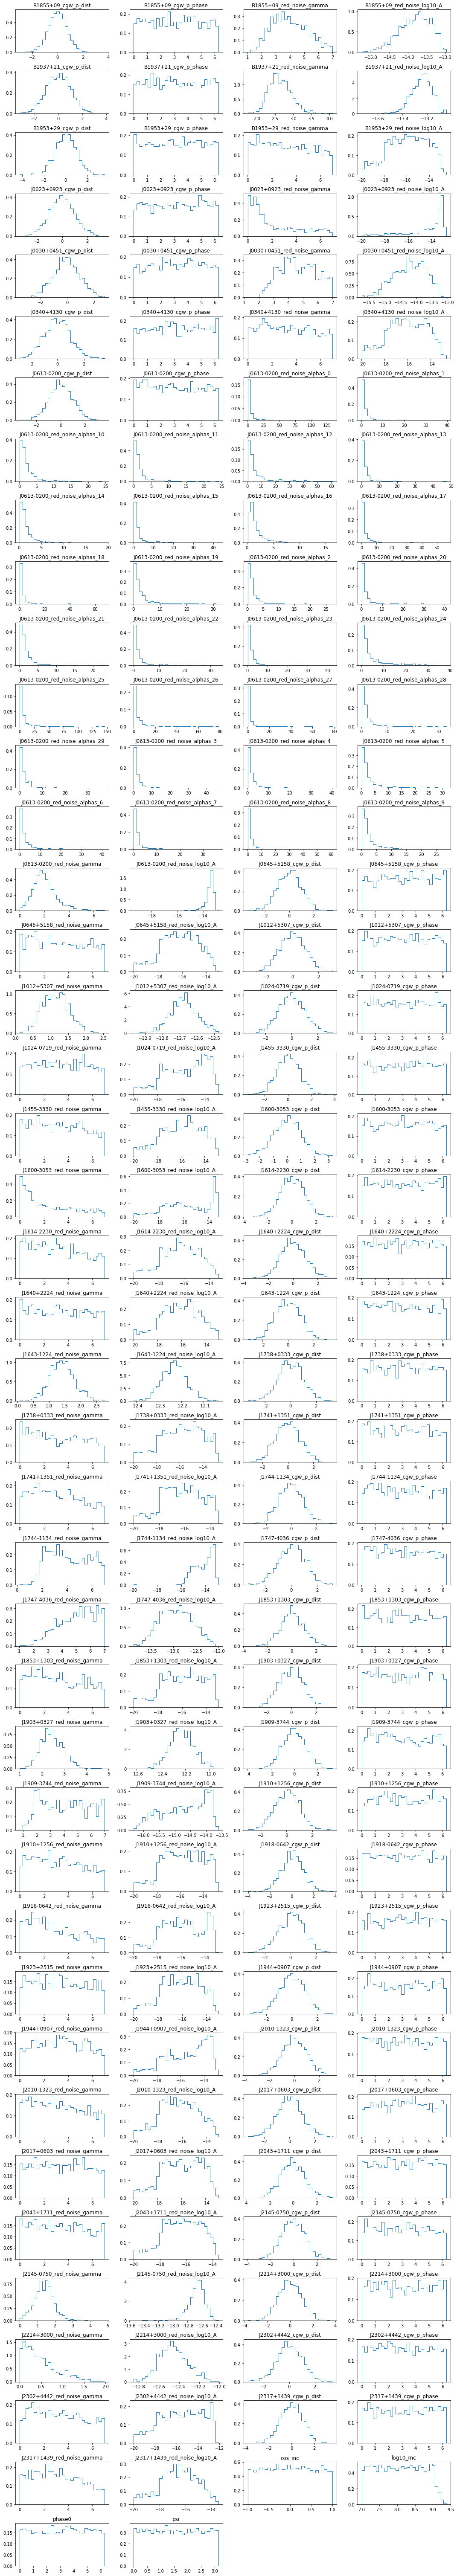

In [4]:
##Which run to inspect? Options: detect, ul, varyF, varyF_medium, model_test
chain = chain_detect
##Which parameters ? Options: singleF, varyF
pars = pars_singleF
Trace = False
Posterior = True

plt.figure(figsize=(15, 2*round(len(pars)/4)))
for ii in range(len(pars)):
    plt.subplot(round(len(pars)/4), 4, ii+1)
    if Trace:
        plt.plot(chain[:,ii])
    if Posterior:
        plt.hist(chain[:,ii], histtype = 'step', density = True, bins = 30);
    plt.title(pars[ii])
plt.tight_layout()

In [5]:
gw_pars_singleF = ['cos_inc', 'log10_mc',  'phase0', 'psi']
gw_pars_varyF = ['cos_inc', 'log10_mc', 'log10_fgw', 'phase0', 'psi']

varyF_gw_inds = [pars_varyF.index(par) for par in gw_pars_varyF]
singleF_gw_inds = [pars_singleF.index(par) for par in gw_pars_singleF]


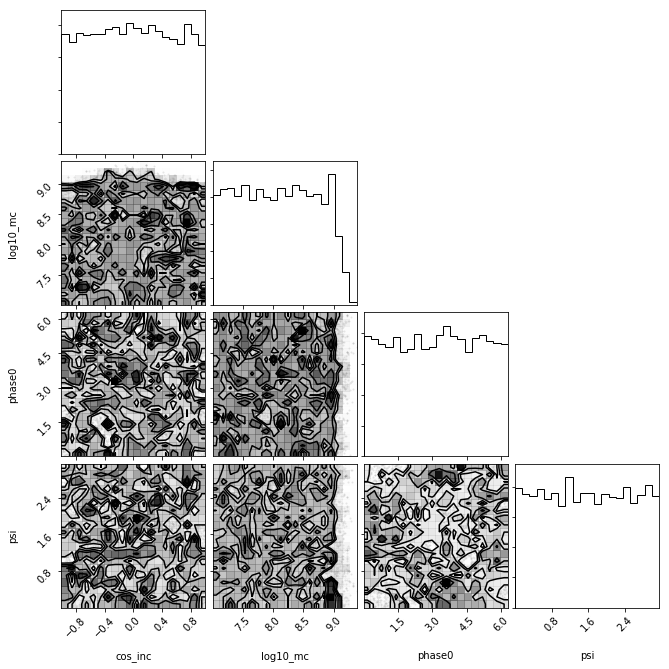

In [6]:
corner.corner(chain_detect[:,singleF_gw_inds], labels = gw_pars_singleF);

# Detection

Bayes Factors can be calculated from runs with log-uniform priors. A reproduction of Figure 2, along with the quoted Savage-Dickey Bayes Factor, is done below.

In [5]:
mc_index = pars_singleF.index('log10_mc')

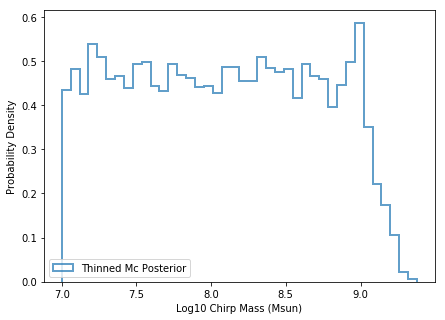

In [6]:
plt.figure(figsize = (7,5))
plt.hist(chain_detect[:,mc_index], bins=40, density=True, lw=2, alpha=0.7, color='C0', histtype='step', 
         label = 'Thinned Mc Posterior');
plt.xlabel('Log10 Chirp Mass (Msun)')
plt.ylabel('Probability Density')
plt.legend(loc = 'lower left');

Here, we make use of the Savage-Dickey Bayes Factor method, described in Equation 23 of the paper. The BF here is the ratio of the prior to the posterior value at a strain amplitude of 0. Since we use a log scale, as well as a fixed source distance, we can approximate a strain amplitude of 0 to correspond to the lower range of our chirp mass prior ($10^7$).

In [27]:
hist = np.histogram(chain_detect[:,mc_index], bins = 40, density = True)
prior = 1/(10.0-7.0)
posterior_low = hist[0][0]
bf = np.float64(prior/posterior_low)
print('SD BF ~ ' +str((bf).round(2)))

SD BF ~ 0.77


# Upper Limit

Upper limits are calculated from runs with a Uniform prior, using the 95th percentile. This value for the chirp mass and a histogram of the samples are calculated and plotted below.

In [41]:
upper_limit = 10**np.percentile(chain_ul[:,mc_index], q=95.0)
s_ul = str((upper_limit/1e9).round(1))
print('Upper Limit = '+s_ul+' x 10^9 Msun')

s_mc = str((np.float64(Mc)/1e8).round(2))

Upper Limit = 1.6 x 10^9 Msun


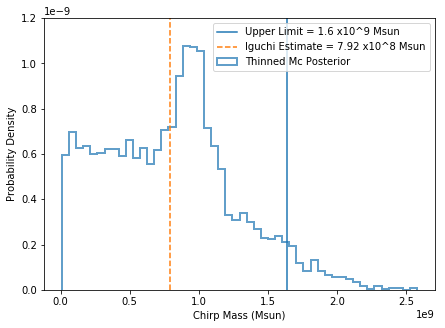

In [9]:
plt.figure(figsize = (7,5))
plt.hist(10**chain_ul[:,mc_index], bins=50, density=True, lw=2, alpha=0.7, color='C0', histtype='step', 
         label = 'Thinned Mc Posterior');
plt.ylim(0,1.2e-9)
plt.axvline(upper_limit, label = 'Upper Limit = '+s_ul+' x10^9 Msun')
plt.axvline(Mc, label = 'Iguchi Estimate = '+s_mc+' x10^8 Msun', color = 'C1', ls = '--')

plt.xlabel('Chirp Mass (Msun)')
plt.ylabel('Probability Density')
plt.legend(loc = 'upper right');

The buildup of samples at $1\times10^9$ Msun is not significant. However, we can investigate the cause of this feature by selecting samples corresponding to this range of chirp masses, and inspecting other related parameters.

In [25]:
#select samples that we want to inspect
phase_1909_ind = pars_singleF.index('J1909-3744_cgw_p_phase')
phase_0613_ind = pars_singleF.index('J0613-0200_cgw_p_phase')
inds = [phase_1909_ind, phase_0613_ind, mc_index]

sub_chain = chain_ul[:,inds]

gw_chain_hump = np.array([chain for chain in sub_chain if chain[2]<np.log10(1.1e9) and chain[2]>np.log10(8e8)])
gw_chain_not = np.array([chain for chain in sub_chain if chain[2]>np.log10(1.1e9) or chain[2]<np.log10(8e8)])

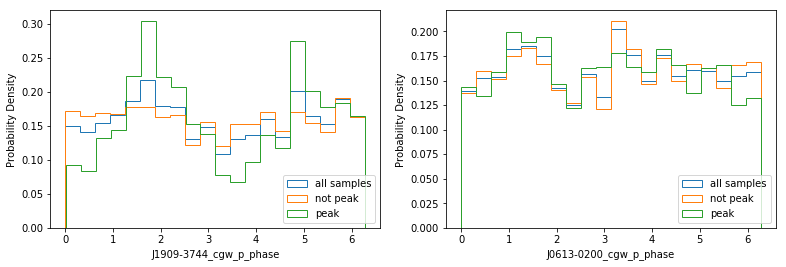

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (13,4))

ax1.hist(sub_chain[:, 0], histtype = 'step', density = True, bins = 20, label = 'all samples');
ax1.hist(gw_chain_not[:, 0], histtype = 'step', density = True, bins = 20, label = 'not peak');
ax1.hist(gw_chain_hump[:, 0], histtype = 'step', density = True, bins = 20, label = 'peak');

ax1.set_xlabel(pars_singleF[phase_1909_ind]);
ax1.set_ylabel('Probability Density');
ax1.legend(loc = 'lower right');

ax2.hist(sub_chain[:, 1], histtype = 'step', density = True, bins = 20, label = 'all samples');
ax2.hist(gw_chain_not[:, 1], histtype = 'step', density = True, bins = 20, label = 'not peak');
ax2.hist(gw_chain_hump[:, 1], histtype = 'step', density = True, bins = 20, label = 'peak');

ax2.set_xlabel(pars_singleF[phase_0613_ind]);
ax2.set_ylabel('Probability Density');
ax2.legend(loc = 'lower right');

In the samples of the GW phases at pulsar J1909-3744, we can see a double peaked structure. As can be seen from the smooth sampling in the trace plots above, this is not due to an issue with the sampler. From this and other work, we've seen this to be an indication that the relevant pulsar is recovering some continuous wave-like signal, potentially noise. Since there is no indication of this in any other pulsar (with one example, J0613-0200, shown), it is likely not a real GW.

# Frequency Prior Testing

To recreate Figures 4 and 5 from the paper, we examine a combination of runs, including two that include GW frequency as a free parameter. By binning the samples from one of these runs into a 2-dimensional histogram, and then taking weighted upper limits of each frequency bin, we can observe how the upper limit changes for each GW frequency, while only conducting a single run.

In [28]:
index_mc = pars_varyF.index('log10_mc')
index_f = pars_varyF.index('log10_fgw')


In [29]:
w_upper_limit = 10**wquantiles.quantile(chain_detect[:,mc_index], 10**chain_detect[:,mc_index], 0.95)
w_upper_limit_medium = 10**wquantiles.quantile(chain_varyF_medium[:,index_mc], 
                                               10**chain_varyF_medium[:,index_mc], 0.95)
w_upper_limit_fullF= 10**wquantiles.quantile(np.array(chain_varyF[:,index_mc]), 
                                        10**np.array(chain_varyF[:,index_mc]), 0.95)

In [30]:
counts,xbins,ybins = np.histogram2d(chain_varyF[:,index_f], chain_varyF[:,index_mc], bins=50)
binned_chains = [ [] for i in range(len(xbins-1)) ]
for i in range(len(xbins)):
    for j in range(len(chain_varyF[:,index_f])):
        if chain_varyF[j,index_f] > xbins[i] and chain_varyF[j,index_f] <= xbins[i+1]:
            binned_chains[i].append(chain_varyF[j,index_mc])
binned_chains = binned_chains[:-1]

In [31]:
weights=[]
for chain in binned_chains:
    ws = []
    for i in range(len(chain)):
        w = 10**chain[i]
        ws.append(w)
    weights.append(ws)

In [32]:
x = [(a + b) / 2.0 for a,b in zip(xbins, xbins[1:])]
uppers = 10**np.array([wquantiles.quantile(np.array(chain), 
                              10**np.array(chain), 0.95) for chain in binned_chains])
log_uppers = np.log10(uppers)

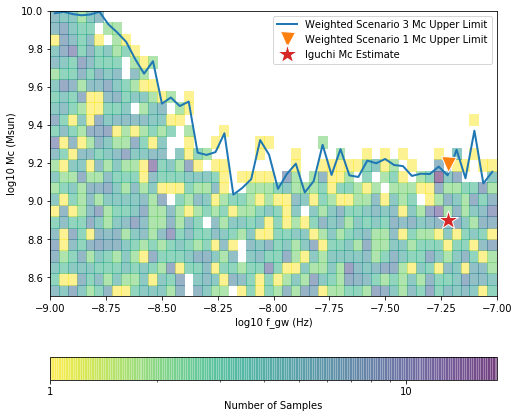

In [33]:
fig, ax = plt.subplots(figsize=(8,7.5))
counts,xbins,ybins,image = ax.hist2d(chain_varyF[:,index_f], chain_varyF[:,index_mc], bins=50, 
                                     norm=colors.LogNorm(), alpha = 0.5, cmap = 'viridis_r')
ax.plot(x, log_uppers, color = 'C0', lw = 2, label = 'Weighted Scenario 3 Mc Upper Limit')
ax.plot(np.log10(f), np.log10(w_upper_limit), marker = 'v', color = 'C1', markeredgecolor = 'w', markersize = 15, 
       label = 'Weighted Scenario 1 Mc Upper Limit', ls = '')
ax.plot(np.log10(f), np.log10(Mc), marker = '*', color = 'C3', markeredgecolor = 'w', markersize = 20, 
       label = 'Iguchi Mc Estimate', ls = '')
plt.ylim(8.5,10)
cbar = plt.colorbar(image, ax = ax, label='Number of Samples', orientation='horizontal')
cbar.ax.set_xticklabels(['1', '10', '100'])  # horizontal colorbar
ax.legend()
ax.set_ylabel('log10 Mc (Msun)');
ax.set_xlabel('log10 f_gw (Hz)');

Note: Because these chains have been thinned, there are fewer samples in each bin compared to the published plot

Starting from this 2D histogram, we can create the curves from Figure 5. By binning the samples in steadily widening regions, and recalculating the weighted upper limit, we can see how wide of a frequency prior we can search over before losing sensitivity (seen as an increase in the Mc upper limit)

In [40]:
u_w = []
uw_err = []
w = np.arange(1,166,5)*log_f_err
w = w[1:]
for i in range(len(w)):
    a = [j for j in range(len(chain_varyF[:,index_f])) if chain_varyF[j,index_f]<log_f+(w[i]) 
         and chain_varyF[j,index_f]>log_f-(w[i])]
    b = chain_varyF[a,:]
    ua = 10**wquantiles.quantile(np.array(b[:,index_mc]), 10**np.array(b[:,index_mc]), 0.95)
    u_w.append(ua)
u_w = np.array(u_w)

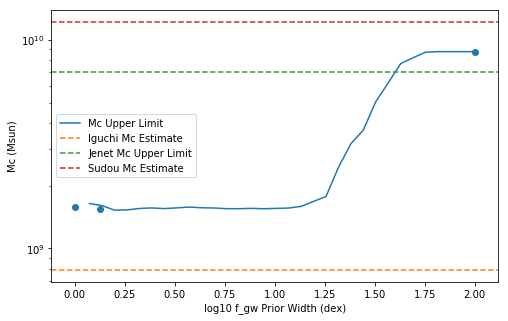

In [35]:
plt.figure(figsize = (8,5))
plt.plot(w,np.array(u_w), label = 'Mc Upper Limit')
plt.semilogy()
plt.scatter(2.0, w_upper_limit_fullF, color = 'C0')
plt.scatter(10*log_f_err, w_upper_limit_medium, color = 'C0')
plt.scatter(0.0, w_upper_limit, color = 'C0')
plt.axhline(Mc, color = 'C1', ls = '--', label = 'Iguchi Mc Estimate')
plt.axhline(jenet, color = 'C2', ls = '--', label = 'Jenet Mc Upper Limit')
plt.axhline(S03Mc, color = 'C3', ls = '--', label = 'Sudou Mc Estimate')
plt.legend();
plt.xlabel('log10 f_gw Prior Width (dex)');
plt.ylabel('Mc (Msun)');

From this curve, we can see that we are able to search 1 dex in log-frequency (or 1 order of magnitude in frequency) before the upper limit starts to increase. This means that a search of this type can be done even for a potential source with large uncertainties on its GW parameters.

# Model Test

To test a specific binary model, and recreate Figure 6, we create priors based on the binary model reported in Iguchi et al. (2010). We inspect these chains, and the results of the runs, below.

Text(0, 0.5, 'Probability Density')

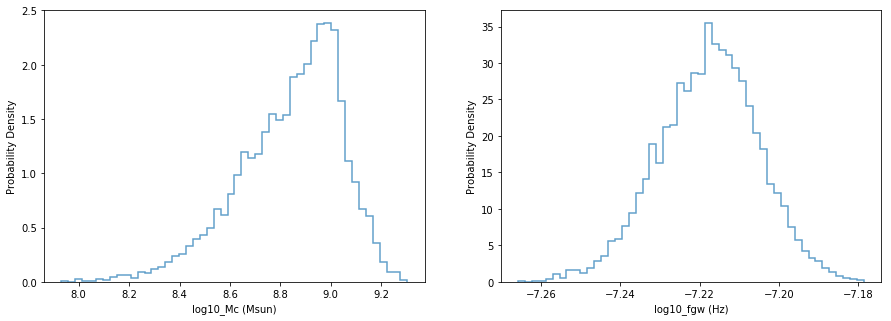

In [36]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))


ax1.hist(chain_model_test[:,index_mc], 50, density=True, lw=1.5, color='C0', 
        histtype= 'step',  alpha = 0.7);
ax2.hist(chain_model_test[:,index_f], 50, density=True, lw=1.5, color='C0', 
        histtype= 'step',  alpha = 0.7);
ax1.set_xlabel('log10_Mc (Msun)')
ax2.set_xlabel('log10_fgw (Hz)')
ax1.set_ylabel('Probability Density')
ax2.set_ylabel('Probability Density')

In [37]:
qs = [50.0, 50+68.27/2, 50-68.27/2]

vals_m=[np.percentile(chain_model_test[:,index_mc], q=q) for q in qs]
vals_f=[np.percentile(chain_model_test[:,index_f], q=q) for q in qs]

In [38]:
print('log10(Mc) = '+str(round(vals_m[0], 2))+'+'+str(round(vals_m[1]-vals_m[0], 2))+
      '-'+str(round(vals_m[0]-vals_m[2],2)))

log10(Mc) = 8.88+0.15-0.24


For the Iguchi estimate, log10(Mc) = $8.90 ^{+0.21}_{-0.24}$. This upper error bar has been changed, meaning that we have gained information about this model, which, in the paper, is quantified through a KL divergence

In [39]:
print('log10(f_gw) = '+str(round(vals_f[0], 3))+'+'+str(round(vals_f[1]-vals_f[0], 3))+
      '-'+str(round(vals_f[0]-vals_f[2],3)))

log10(f_gw) = -7.217+0.012-0.013


For the Iguchi estimate, log10(f_gw) = $-7.219 \pm 0.012$, which is consistent with our posterior